In [2]:
# Add know to output

In [ ]:
# Add x to input

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import random
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from tqdm import tqdm

In [4]:
class FFNN(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, n_layers, activation='relu'):
        super().__init__()
        layers = []

        if activation == 'relu':
            activation_function = nn.ReLU
        elif activation == 'tanh':
            activation_function = nn.Tanh
        
        # Input layer
        layers.append(nn.Linear(input_dim, hidden_dim))
        layers.append(activation_function())
        
        # Hidden layers
        for _ in range(n_layers - 1):
            layers.append(nn.Linear(hidden_dim, hidden_dim))
            layers.append(activation_function())
        
        # Output layer
        layers.append(nn.Linear(hidden_dim, output_dim))  # output size is 1
        
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)

In [5]:
def train_to_convergence(model,
                         x_train,
                         y_train,
                         optimizer,
                         criterion,
                         loss_threshold=0.01,
                         max_epochs=1000):
    
    #pbar = tqdm(range(max_epochs), desc="Training", unit="epoch")
    #for epoch in pbar:
    for epoch in range(max_epochs):
        model.train()
        
        optimizer.zero_grad()
        outputs = model(x_train)
        loss = criterion(outputs, y_train)

        if loss.item() < loss_threshold:
            break

        loss.backward()
        optimizer.step()
        
        # Update progress bar description
        #bar.set_postfix(loss=loss.item())


In [24]:
class CircleDataset:

    def __init__(self, dim=2, p_new=0.5):

        self.dim = dim
        self.p_new = p_new
        
        self.x_list = []
        self.y_class_list = []
        self.y_new_list = []
        self.y_know_list = []

        self.curr_idx = None

    def generate_sample(self):

        if len(self.x_list) == 0 or random.random() < self.p_new:

            if random.random() < 0.5:
                magnitude = random.random()
                y_class = 0
            else:
                magnitude = random.random() + 2
                y_class = 1

            vector = torch.randn(self.dim)
            x = magnitude * (vector / vector.norm())

            y_new = 1

            self.x_list.append(x)
            self.y_class_list.append(y_class)
            self.y_new_list.append(y_new)

            self.curr_idx = len(self.x_list) - 1
            self.y_know_list.append(None)
        
        else:

            idx = np.random.randint(low=0, high=len(self.x_list))
            x = self.x_list[idx]
            y_class = self.y_class_list[idx]
            y_new = 0
            self.y_new_list[idx] = y_new
            self.curr_idx = idx

        return x.unsqueeze(0), torch.tensor([y_class, y_new])

    def update_know(self, know):

        self.y_know_list[self.curr_idx] = know
    
    def get_train(self):

        x_tensor = torch.stack(self.x_list, dim=0)
        y_class_tensor = torch.tensor(self.y_class_list, dtype=torch.float32).unsqueeze(1)
        y_new_tensor = torch.tensor(self.y_new_list, dtype=torch.float32).unsqueeze(1)
        y_know_tensor = torch.tensor(self.y_know_list, dtype=torch.float32).unsqueeze(1)
        y_tensor = torch.cat((y_class_tensor, y_new_tensor, y_know_tensor), dim=1)

        return x_tensor, y_tensor
    

In [37]:
#
# Training Loop
#

# Hyperparameters
n_iterations = 1000
input_dim = 100
output_dim = 3
hidden_dim = 256
n_layers = 2
loss_threshold = 0.01  # stop training when loss falls below this
max_epochs = 1000
learning_rate = 1e-3
weight_decay = 0
activation = 'relu'
criterion_name = 'mae'
if criterion_name == 'mse':
    criterion = nn.MSELoss()
elif criterion_name == 'mae':
    criterion = nn.L1Loss()
elif criterion_name == 'log_loss':
    criterion = nn.BCEWithLogitsLoss()

# Initialize model and optimizer (should it/they be reoptimized every time?)
model = FFNN(input_dim, hidden_dim, output_dim, n_layers, activation)
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

# Initialize dataset
dataset = CircleDataset(dim=input_dim)

# Initialize record-keeping
class_true = []
class_pred = []
new_true = []
new_pred = []
know_true = []
know_pred = []

# Run online learning iterations
for iteration in tqdm(range(n_iterations)):
    
    # Encounter new sample
    x, y = dataset.generate_sample()
    class_true.append(y[0].item())
    new_true.append(y[1].item())

    # Collect prediction
    model.eval()
    with torch.no_grad():
        pred = model(x)
        class_pred.append(pred[0][0].item())
        new_pred.append(pred[0][1].item())
        know_pred.append(pred[0][2].item())
        know = ((class_pred[-1] > 0.5) == class_true[-1])
        know_true.append(know)
        dataset.update_know(know)

    # Update model
    x_train, y_train = dataset.get_train()
    train_to_convergence(model, x_train, y_train, 
                         optimizer, criterion,
                         loss_threshold=loss_threshold)
    

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:08<00:00, 116.51it/s]


In [46]:
# Train meta-model with same parameters

meta_input_dim = 3
meta_loss_threshold = 0.01

# Initialize model and optimizer
meta_model = FFNN(meta_input_dim, hidden_dim, output_dim, n_layers, activation)
meta_optimizer = optim.Adam(meta_model.parameters(), lr=learning_rate, weight_decay=weight_decay)

# Initialize dataset

class_pred_tensor = torch.tensor(class_pred, dtype=torch.float32).unsqueeze(1)
new_pred_tensor = torch.tensor(new_pred, dtype=torch.float32).unsqueeze(1)
know_pred_tensor = torch.tensor(know_pred, dtype=torch.float32).unsqueeze(1)
meta_x_train = torch.cat((class_pred_tensor, new_pred_tensor, know_pred_tensor), dim=1)

#meta_x_train = torch.cat((base_model_output_train, x_train), dim=1)

class_true_tensor = torch.tensor(class_true, dtype=torch.float32).unsqueeze(1)
new_true_tensor = torch.tensor(new_true, dtype=torch.float32).unsqueeze(1)
know_true_tensor = torch.tensor(know_true, dtype=torch.float32).unsqueeze(1)
meta_y_train = torch.cat((class_true_tensor, new_true_tensor, know_true_tensor), dim=1)

# Initialize record-keeping
meta_class_pred = []
meta_new_pred = []
meta_know_pred = []

# Run online learning iterations
for iteration in tqdm(range(n_iterations)):
    
    # Collect prediction
    meta_model.eval()
    with torch.no_grad():
        meta_pred = meta_model(meta_x_train[iteration])
        meta_class_pred.append(meta_pred[0].item())
        meta_new_pred.append(meta_pred[1].item())
        meta_know_pred.append(meta_pred[2].item())
        
    # Get current data set
    x_train = meta_x_train[:iteration + 1]
    y_train = meta_y_train[:iteration + 1]

    # Update meta-model
    train_to_convergence(meta_model, x_train, y_train, meta_optimizer, criterion, loss_threshold=meta_loss_threshold)    

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [01:55<00:00,  8.67it/s]


In [40]:
# Compute accuracy of base model and meta-model
def accuracy(true, preds, threshold=0.5):
    return (true == (np.array(preds) > threshold)).mean()

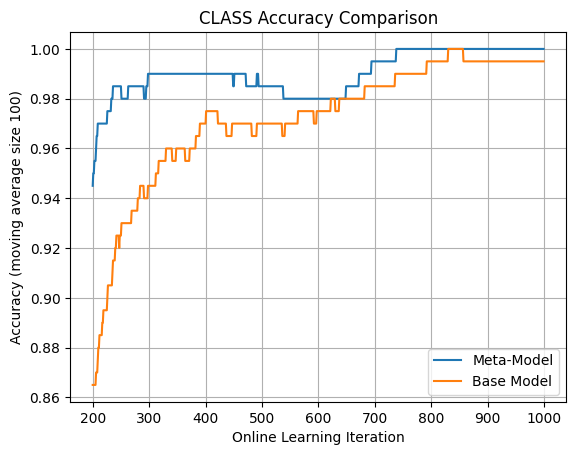

In [47]:
# Plot accuracies over time
for threshold in [0.5]:
    window_size = 200
    base_accs = []
    meta_accs = []
    for i in range(window_size, len(class_true)):
        base_accs.append(accuracy(class_true[i-window_size:i], class_pred[i-window_size:i]))
        meta_accs.append(accuracy(class_true[i-window_size:i], meta_class_pred[i-window_size:i], threshold))
    
    plt.plot(np.arange(window_size, len(class_true)), meta_accs, label='Meta-Model')
    plt.plot(np.arange(window_size, len(class_true)), base_accs, label='Base Model')
    plt.legend()
    plt.ylabel("Accuracy (moving average size 100)")
    plt.xlabel("Online Learning Iteration")
    plt.title(f"CLASS Accuracy Comparison")
    plt.grid()
    plt.show()

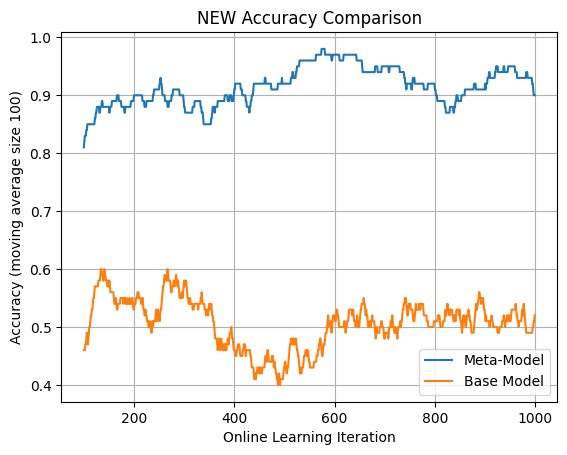

In [48]:
# Plot accuracies over time
for threshold in [0.5]:
    window_size = 100
    base_accs = []
    meta_accs = []
    for i in range(window_size, len(class_true)):
        base_accs.append(accuracy(new_true[i-window_size:i], new_pred[i-window_size:i]))
        meta_accs.append(accuracy(new_true[i-window_size:i], meta_new_pred[i-window_size:i], threshold))
    
    plt.plot(np.arange(window_size, len(new_true)), meta_accs, label='Meta-Model')
    plt.plot(np.arange(window_size, len(new_true)), base_accs, label='Base Model')
    plt.legend()
    plt.ylabel("Accuracy (moving average size 100)")
    plt.xlabel("Online Learning Iteration")
    plt.title(f"NEW Accuracy Comparison")
    plt.grid()
    plt.show()

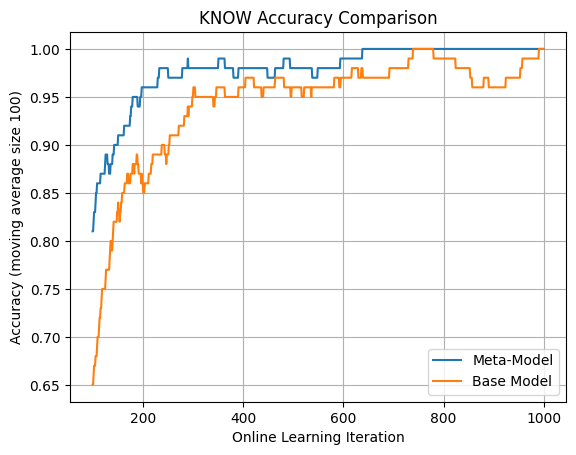

In [49]:
# Plot accuracies over time
for threshold in [0.5]:
    window_size = 100
    base_accs = []
    meta_accs = []
    for i in range(window_size, len(know_true)):
        base_accs.append(accuracy(know_true[i-window_size:i], know_pred[i-window_size:i]))
        meta_accs.append(accuracy(know_true[i-window_size:i], meta_know_pred[i-window_size:i], threshold))
    
    plt.plot(np.arange(window_size, len(know_true)), meta_accs, label='Meta-Model')
    plt.plot(np.arange(window_size, len(know_true)), base_accs, label='Base Model')
    plt.legend()
    plt.ylabel("Accuracy (moving average size 100)")
    plt.xlabel("Online Learning Iteration")
    plt.title(f"KNOW Accuracy Comparison")
    plt.grid()
    plt.show()

In [50]:
# Normalize know across classes.
# Can use noise or circle overlap if need more "don't know" examples

Text(0.5, 1.0, 'Class Predictions')

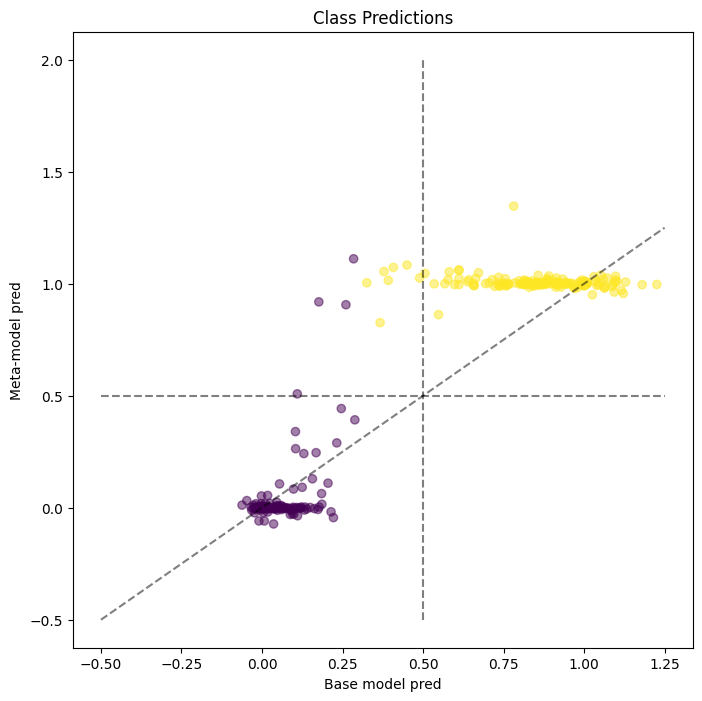

In [66]:
start_idx = 400

plt.figure(figsize=(8,8))
plt.plot([0.5, 0.5], [-0.5, 2.0], linestyle='dashed', color='black', alpha=0.5)
plt.plot([-0.5, 1.25], [0.5, 0.5], linestyle='dashed', color='black', alpha=0.5)
plt.plot([-0.5, 1.25], [-0.5, 1.25], linestyle='dashed', color='black', alpha=0.5)
plt.scatter(class_pred[start_idx:],
            meta_class_pred[start_idx:], 
            c=class_true[start_idx:],
            alpha=0.5)

plt.xlabel("Base model pred")
plt.ylabel("Meta-model pred")
plt.title("Class Predictions")

Text(0.5, 1.0, 'New Predictions')

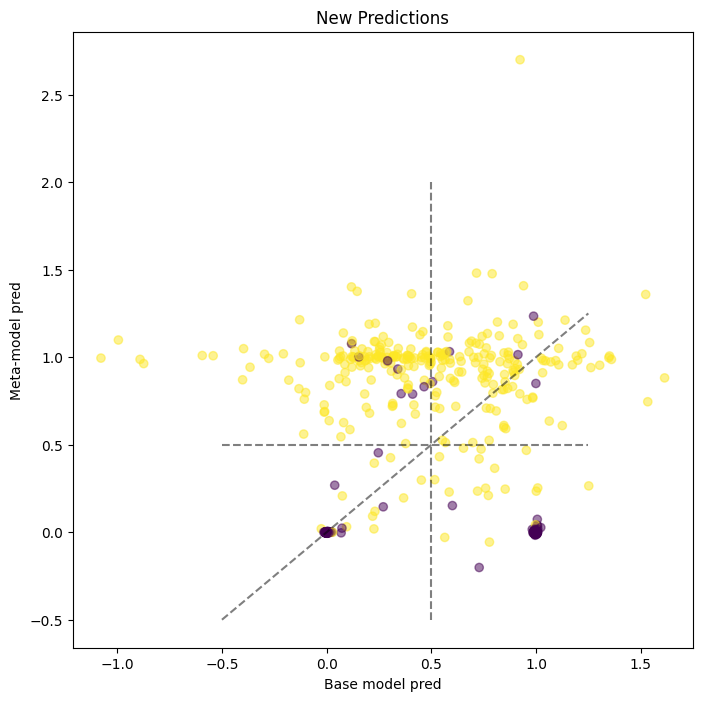

In [67]:
start_idx = 400

plt.figure(figsize=(8,8))
plt.plot([0.5, 0.5], [-0.5, 2.0], linestyle='dashed', color='black', alpha=0.5)
plt.plot([-0.5, 1.25], [0.5, 0.5], linestyle='dashed', color='black', alpha=0.5)
plt.plot([-0.5, 1.25], [-0.5, 1.25], linestyle='dashed', color='black', alpha=0.5)
plt.scatter(new_pred[start_idx:],
            meta_new_pred[start_idx:], 
            c=new_true[start_idx:],
            alpha=0.5)

plt.xlabel("Base model pred")
plt.ylabel("Meta-model pred")
plt.title("New Predictions")

Text(0.5, 1.0, 'Know Predictions')

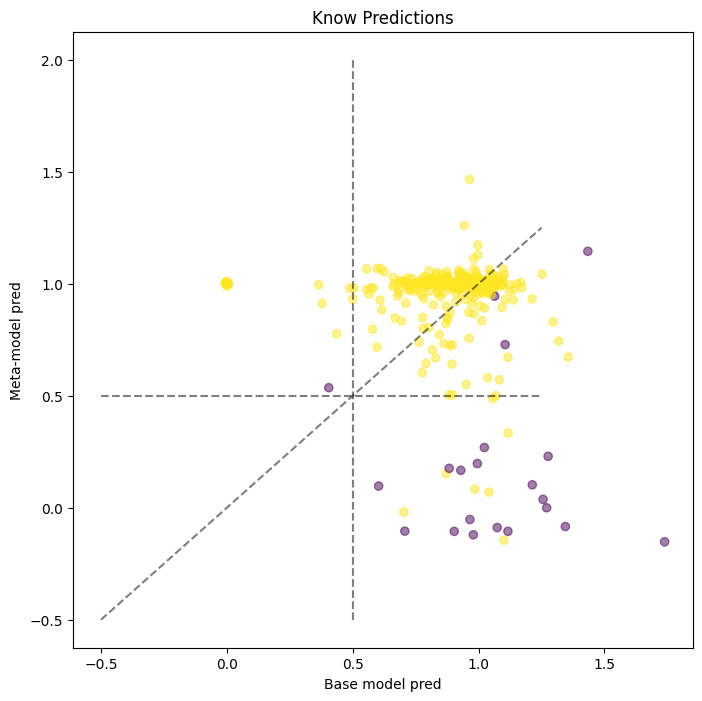

In [69]:
start_idx = 100

plt.figure(figsize=(8,8))
plt.plot([0.5, 0.5], [-0.5, 2.0], linestyle='dashed', color='black', alpha=0.5)
plt.plot([-0.5, 1.25], [0.5, 0.5], linestyle='dashed', color='black', alpha=0.5)
plt.plot([-0.5, 1.25], [-0.5, 1.25], linestyle='dashed', color='black', alpha=0.5)
plt.scatter(know_pred[start_idx:],
            meta_know_pred[start_idx:], 
            c=know_true[start_idx:],
            alpha=0.5)

plt.xlabel("Base model pred")
plt.ylabel("Meta-model pred")
plt.title("Know Predictions")

In [70]:
meta_model

FFNN(
  (model): Sequential(
    (0): Linear(in_features=3, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=256, bias=True)
    (3): ReLU()
    (4): Linear(in_features=256, out_features=3, bias=True)
  )
)

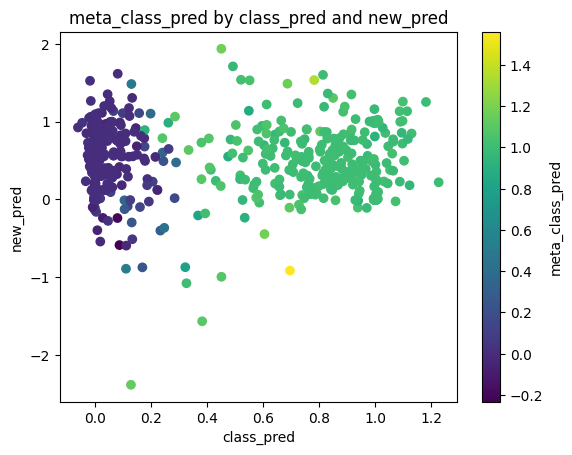

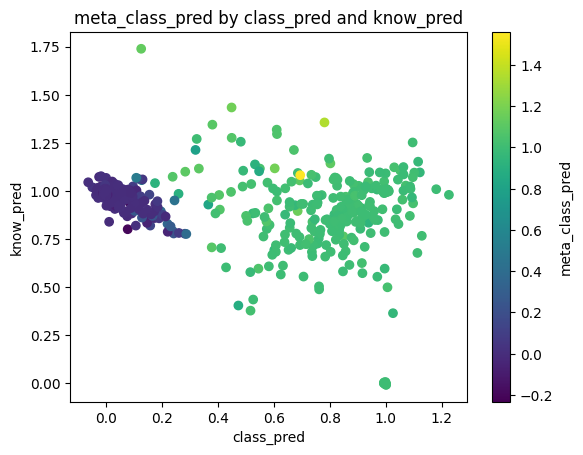

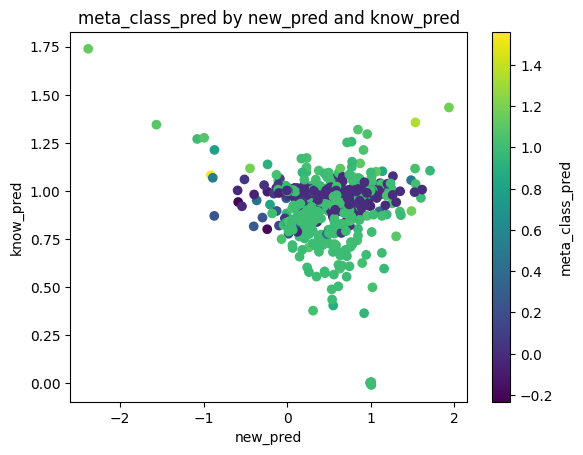

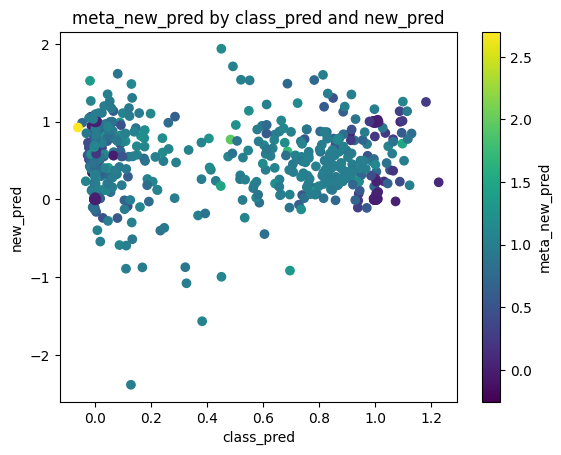

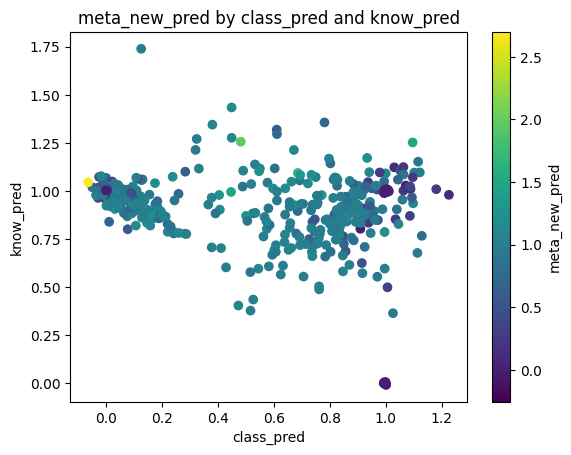

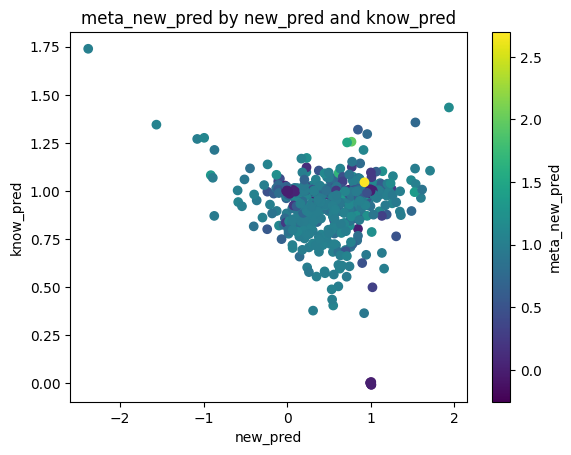

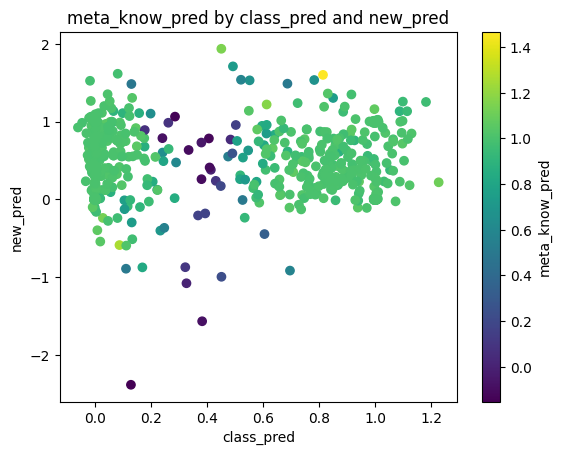

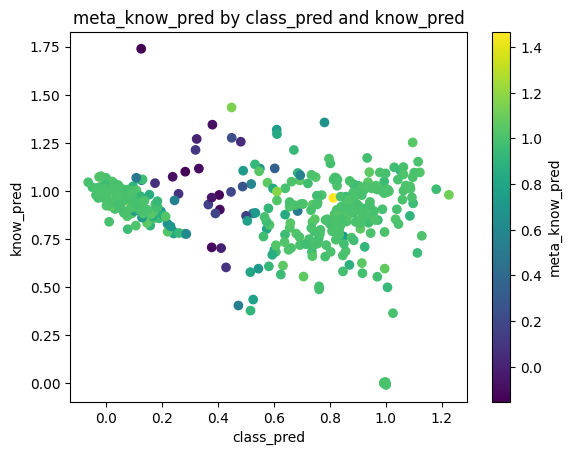

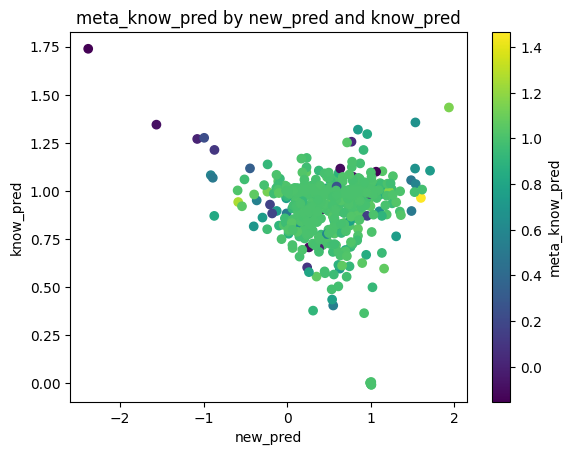

In [75]:
pred_dict = {
    'class_pred': class_pred,
    'new_pred': new_pred,
    'know_pred': know_pred,
    'meta_class_pred': meta_class_pred,
    'meta_new_pred': meta_new_pred,
    'meta_know_pred': meta_know_pred,
}

color_list = ['meta_class_pred', 'meta_new_pred', 'meta_know_pred']

axis_list = [
    ('class_pred', 'new_pred'),
    ('class_pred', 'know_pred'),
    ('new_pred', 'know_pred')
]

start_idx = 100

for color in color_list:
    color_preds = pred_dict[color][start_idx:]
    for x, y in axis_list:
        x_preds = pred_dict[x][start_idx:]
        y_preds = pred_dict[y][start_idx:]

        scatter = plt.scatter(x_preds, y_preds, c=color_preds)
        plt.colorbar(scatter, label=color)
        plt.xlabel(x)
        plt.ylabel(y)
        plt.title(f"{color} by {x} and {y}")
        plt.show()


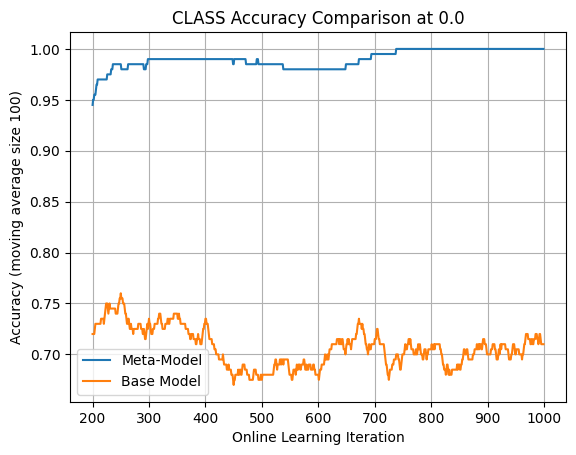

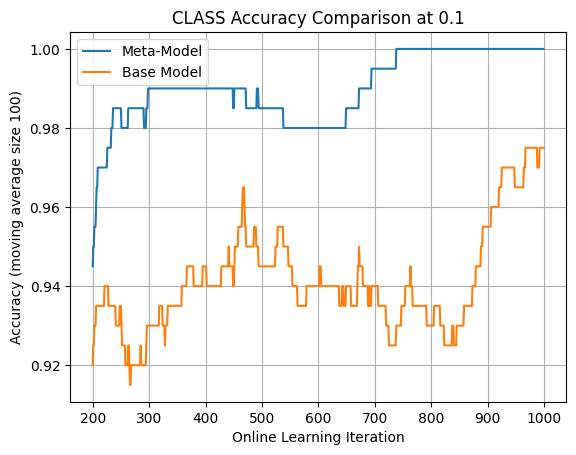

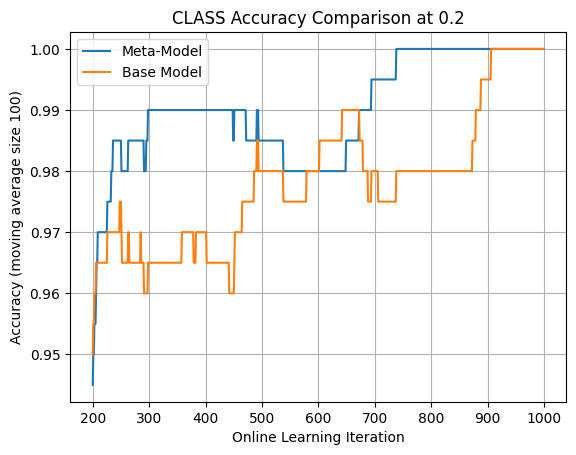

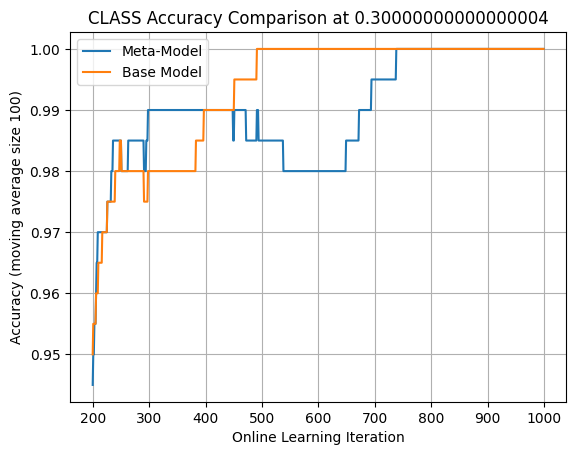

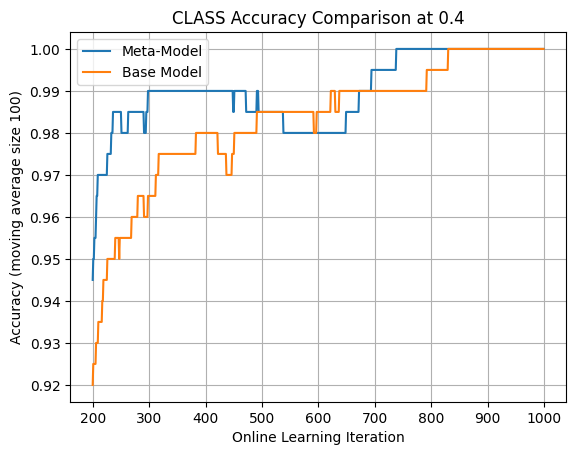

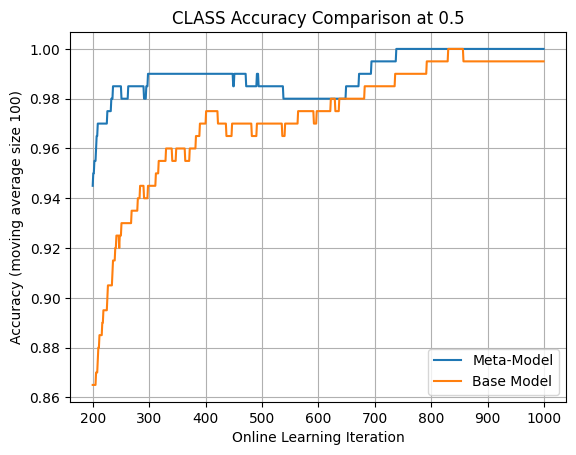

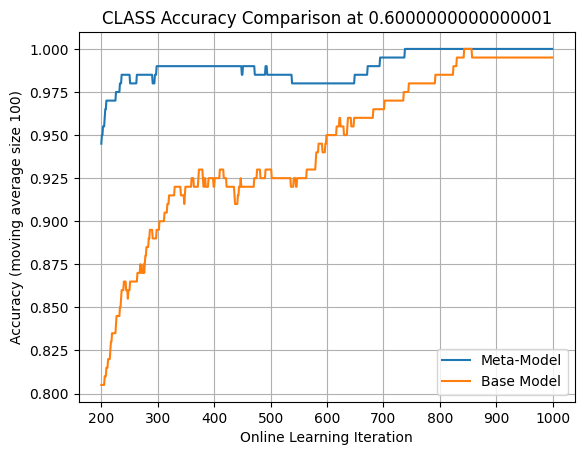

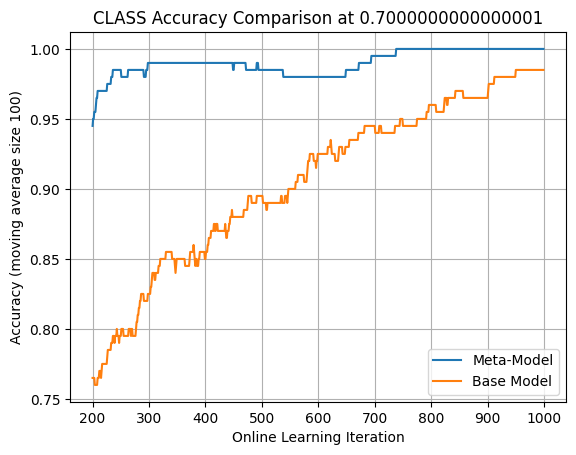

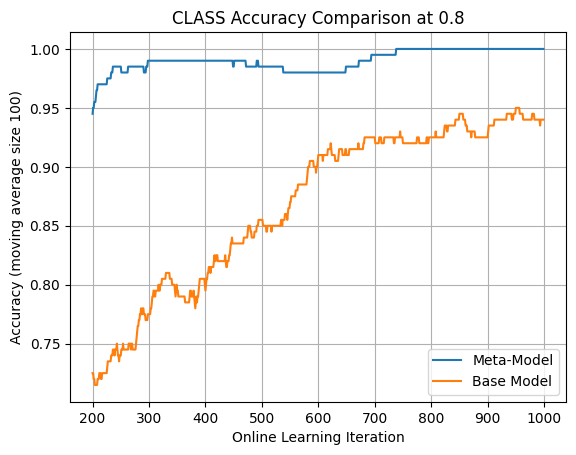

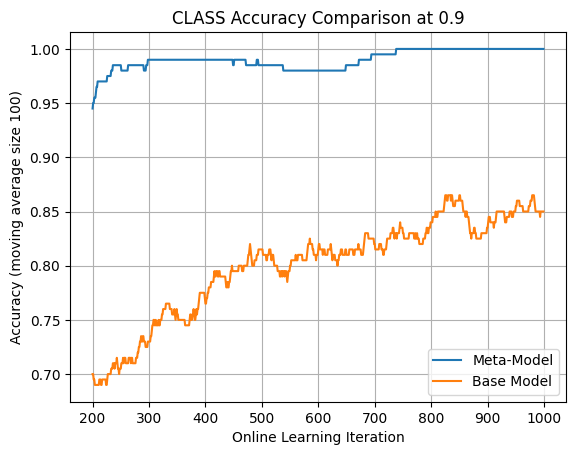

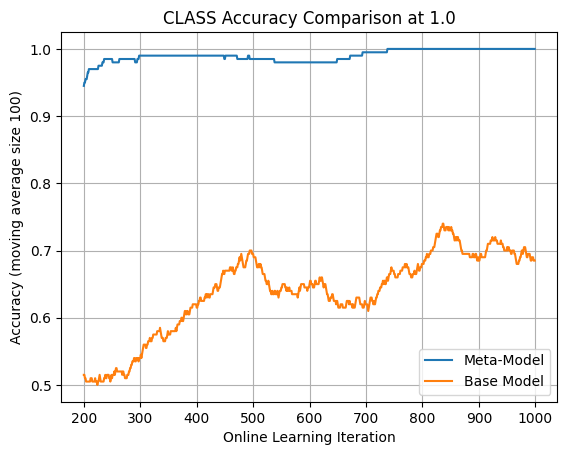

In [78]:
# Plot accuracies over time
for threshold in np.linspace(0, 1, 11):
    window_size = 200
    base_accs = []
    meta_accs = []
    for i in range(window_size, len(class_true)):
        base_accs.append(accuracy(class_true[i-window_size:i], class_pred[i-window_size:i], threshold))
        meta_accs.append(accuracy(class_true[i-window_size:i], meta_class_pred[i-window_size:i], 0.5))
    
    plt.plot(np.arange(window_size, len(class_true)), meta_accs, label='Meta-Model')
    plt.plot(np.arange(window_size, len(class_true)), base_accs, label='Base Model')
    plt.legend()
    plt.ylabel("Accuracy (moving average size 100)")
    plt.xlabel("Online Learning Iteration")
    plt.title(f"CLASS Accuracy Comparison at {threshold}")
    plt.grid()
    plt.show()

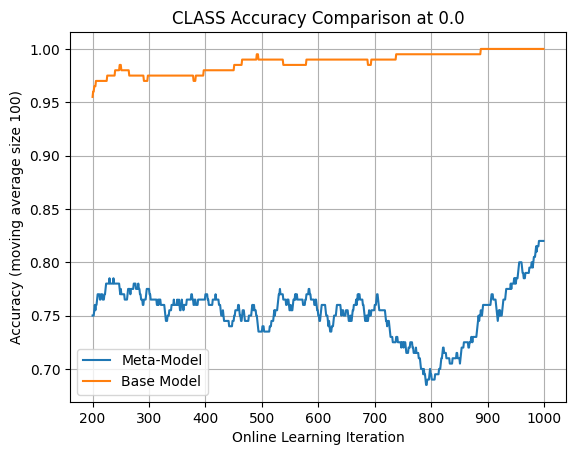

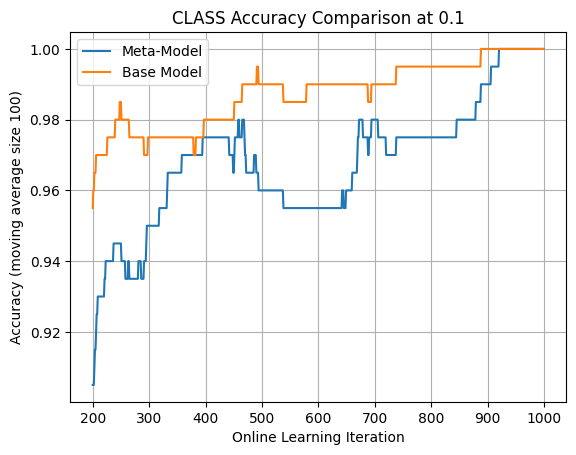

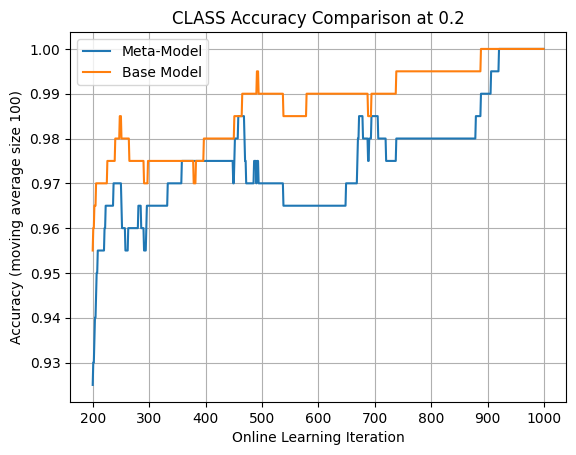

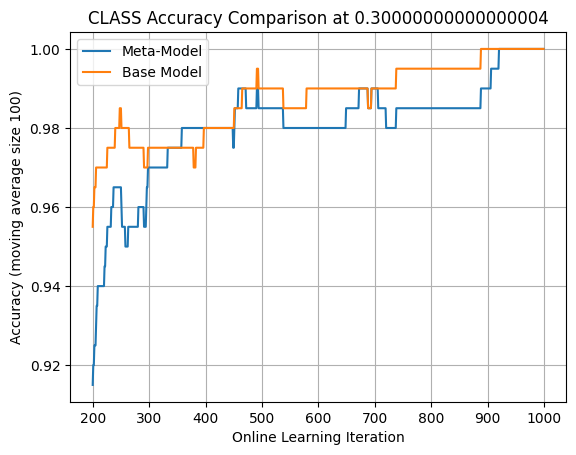

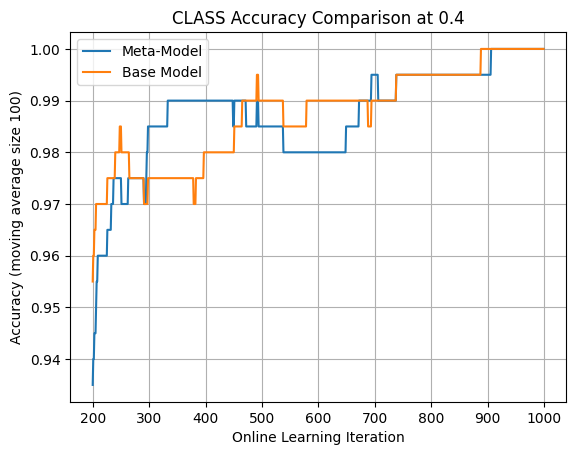

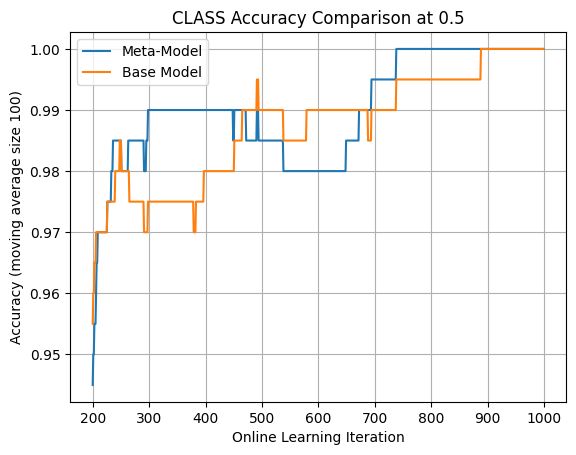

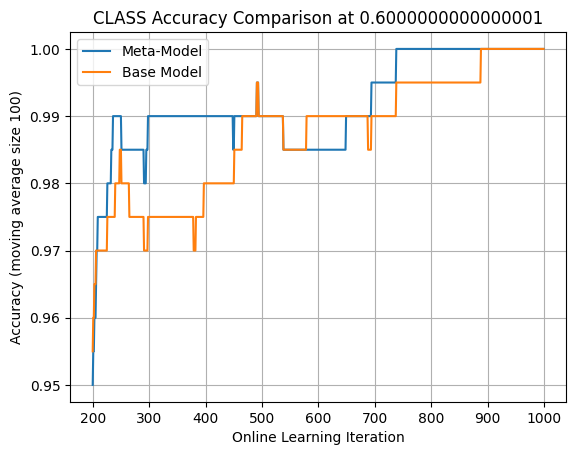

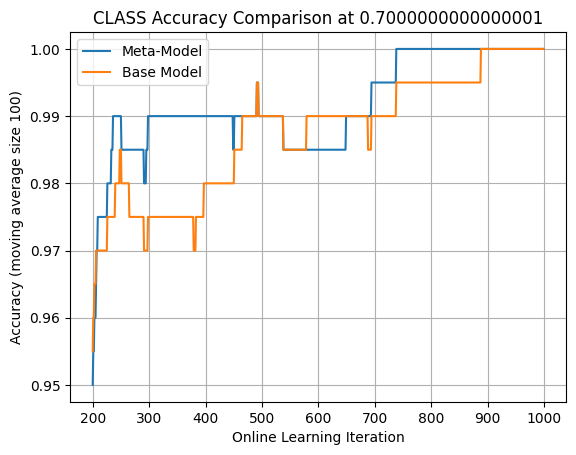

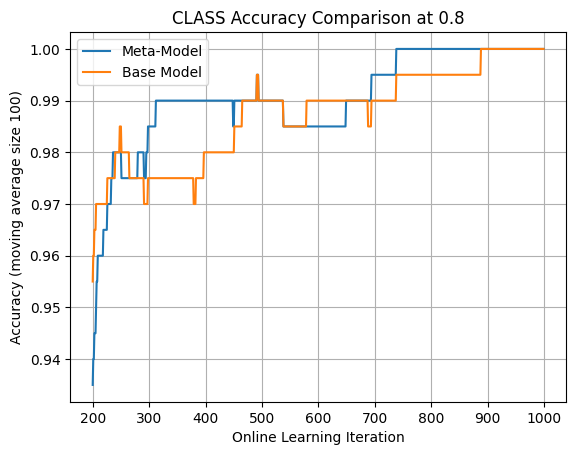

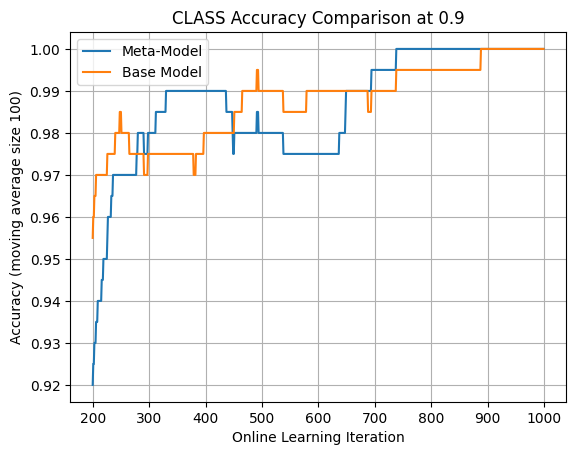

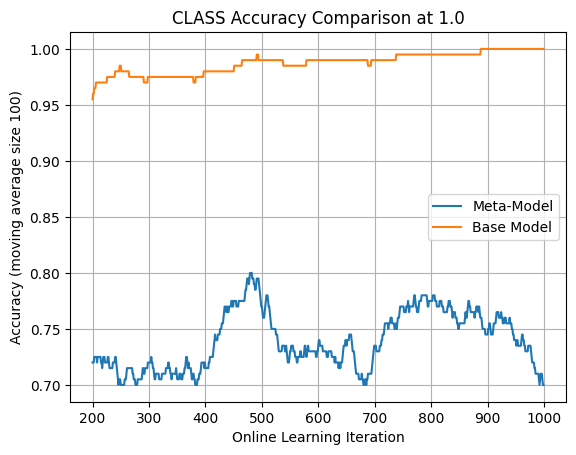

In [79]:
# Plot accuracies over time
for threshold in np.linspace(0, 1, 11):
    window_size = 200
    base_accs = []
    meta_accs = []
    for i in range(window_size, len(class_true)):
        base_accs.append(accuracy(class_true[i-window_size:i], class_pred[i-window_size:i], 0.25))
        meta_accs.append(accuracy(class_true[i-window_size:i], meta_class_pred[i-window_size:i], threshold))
    
    plt.plot(np.arange(window_size, len(class_true)), meta_accs, label='Meta-Model')
    plt.plot(np.arange(window_size, len(class_true)), base_accs, label='Base Model')
    plt.legend()
    plt.ylabel("Accuracy (moving average size 100)")
    plt.xlabel("Online Learning Iteration")
    plt.title(f"CLASS Accuracy Comparison at {threshold}")
    plt.grid()
    plt.show()

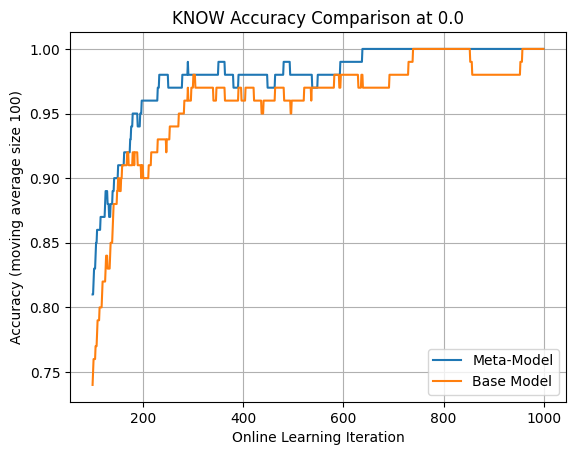

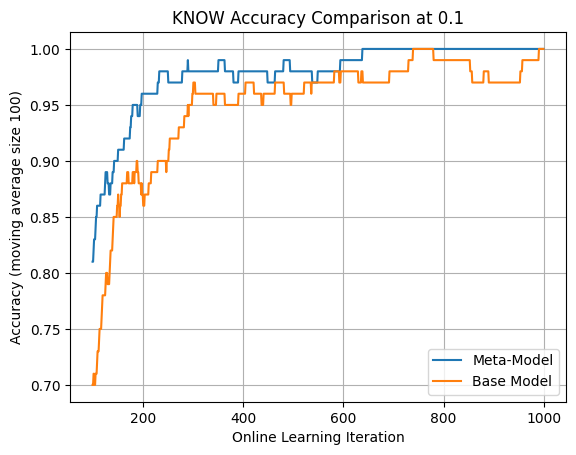

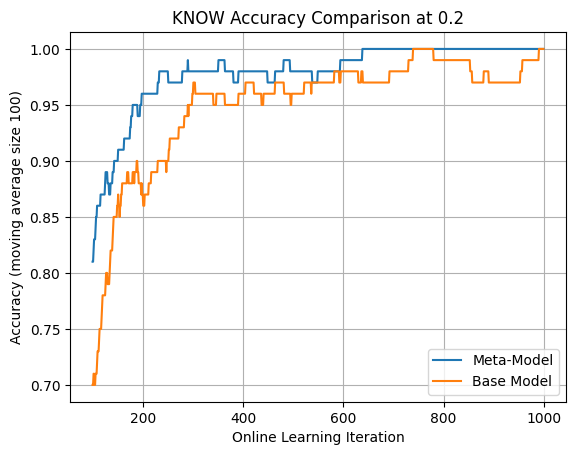

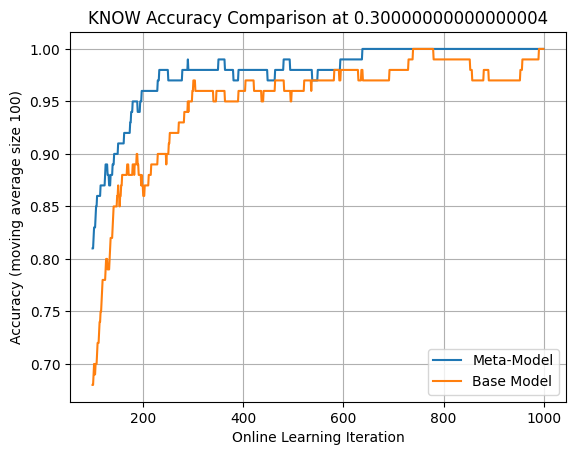

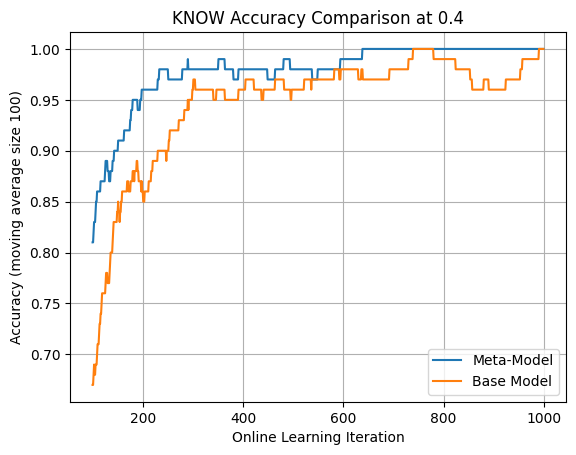

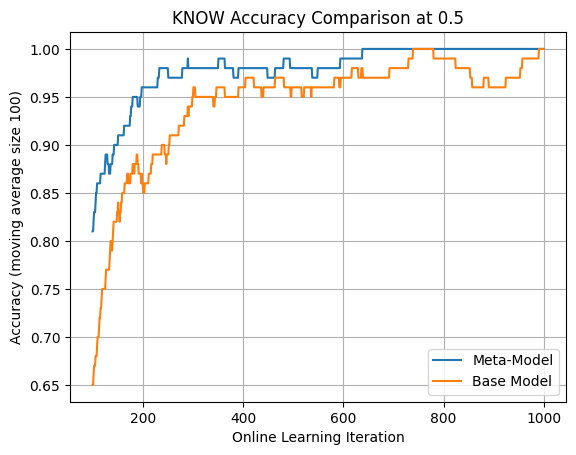

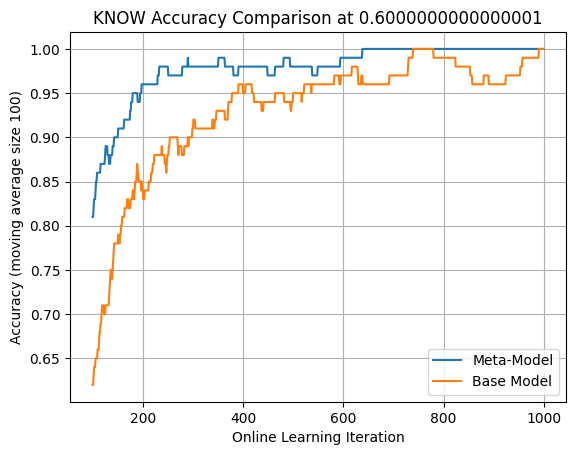

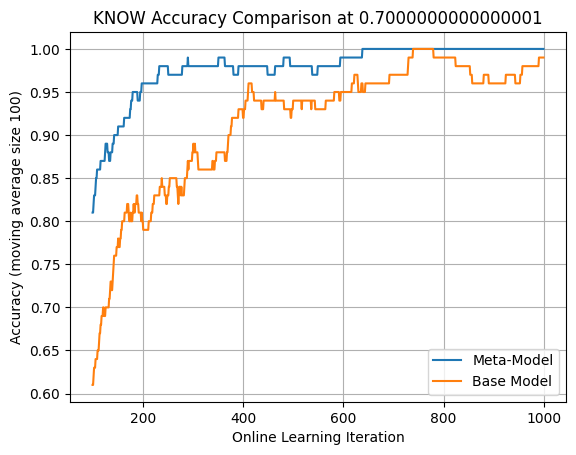

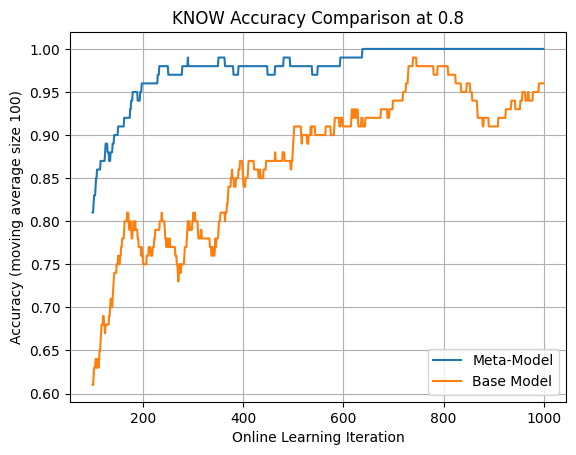

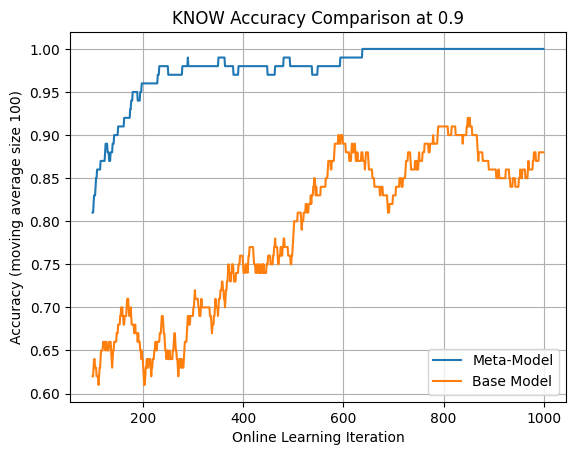

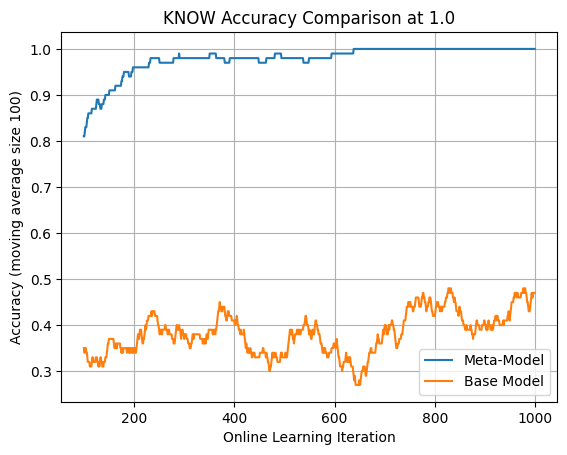

In [83]:
# Plot accuracies over time
for threshold in np.linspace(0.0, 1.0, 11):
    window_size = 100
    base_accs = []
    meta_accs = []
    for i in range(window_size, len(know_true)):
        base_accs.append(accuracy(know_true[i-window_size:i], know_pred[i-window_size:i], threshold))
        meta_accs.append(accuracy(know_true[i-window_size:i], meta_know_pred[i-window_size:i], 0.5))
    
    plt.plot(np.arange(window_size, len(know_true)), meta_accs, label='Meta-Model')
    plt.plot(np.arange(window_size, len(know_true)), base_accs, label='Base Model')
    plt.legend()
    plt.ylabel("Accuracy (moving average size 100)")
    plt.xlabel("Online Learning Iteration")
    plt.title(f"KNOW Accuracy Comparison at {threshold}")
    plt.grid()
    plt.show()

In [95]:
filter_know_pred = (np.array(class_pred) < 0.25) | (np.array(class_pred) > 0.5)

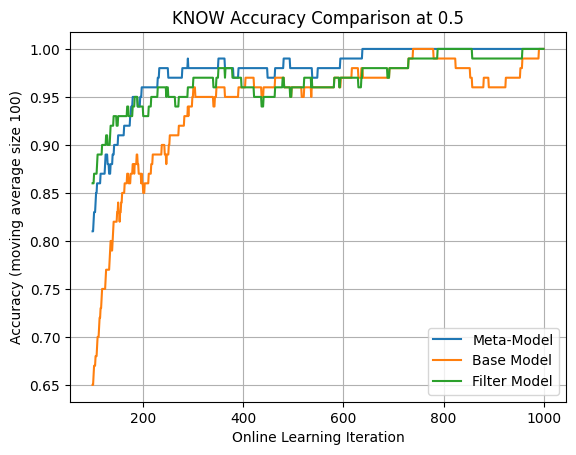

In [96]:
# Plot accuracies over time
for threshold in [0.5]:
    window_size = 100
    base_accs = []
    meta_accs = []
    filter_accs = []
    for i in range(window_size, len(know_true)):
        base_accs.append(accuracy(know_true[i-window_size:i], know_pred[i-window_size:i], threshold))
        meta_accs.append(accuracy(know_true[i-window_size:i], meta_know_pred[i-window_size:i], 0.5))
        filter_accs.append(np.mean(filter_know_pred[i-window_size:i]))
    
    plt.plot(np.arange(window_size, len(know_true)), meta_accs, label='Meta-Model')
    plt.plot(np.arange(window_size, len(know_true)), base_accs, label='Base Model')
    plt.plot(np.arange(window_size, len(know_true)), filter_accs, label='Filter Model')
    plt.legend()
    plt.ylabel("Accuracy (moving average size 100)")
    plt.xlabel("Online Learning Iteration")
    plt.title(f"KNOW Accuracy Comparison at {threshold}")
    plt.grid()
    plt.show()

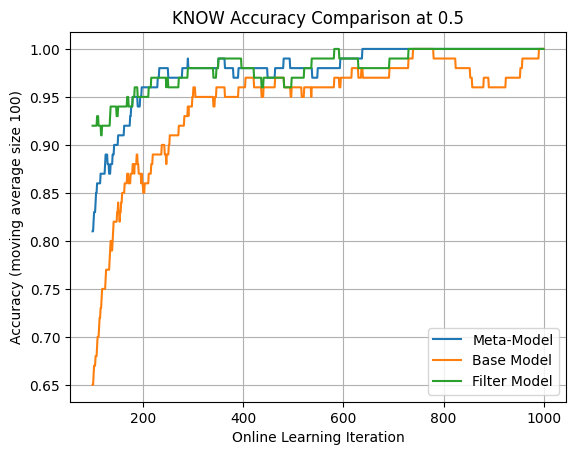

In [101]:
# Plot accuracies over time
filter_know_pred = (np.array(class_pred) < 0.3) | (np.array(class_pred) > 0.45)
for threshold in [0.5]:
    window_size = 100
    base_accs = []
    meta_accs = []
    filter_accs = []
    for i in range(window_size, len(know_true)):
        base_accs.append(accuracy(know_true[i-window_size:i], know_pred[i-window_size:i], threshold))
        meta_accs.append(accuracy(know_true[i-window_size:i], meta_know_pred[i-window_size:i], 0.5))
        filter_accs.append(np.mean(filter_know_pred[i-window_size:i]))
    
    plt.plot(np.arange(window_size, len(know_true)), meta_accs, label='Meta-Model')
    plt.plot(np.arange(window_size, len(know_true)), base_accs, label='Base Model')
    plt.plot(np.arange(window_size, len(know_true)), filter_accs, label='Filter Model')
    plt.legend()
    plt.ylabel("Accuracy (moving average size 100)")
    plt.xlabel("Online Learning Iteration")
    plt.title(f"KNOW Accuracy Comparison at {threshold}")
    plt.grid()
    plt.show()